In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [170]:

#sliding window [[x1, x2, x3], [x2,x3,x4], [x3, x4, x5]....[]] - > [[apl1_t3, apl2_t3, apl3_t3, ....], [apl1_t4, apl2_t4, apl3_t4, ....], ....]
def create_windowed_dataset(df, window_size):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex.")

    # Extract 'total_consumption' feature
    total_consumption = df['total_consumption'].values

    # Create feature windows for 'total_consumption'
    X = np.array([total_consumption[i:i + window_size] for i in range(len(total_consumption) - window_size + 1)])

    # Extract time features (hour of day, day of week)
    hours = df.index.hour
    days_of_week = df.index.weekday

    # Calculate cyclic time features (sin and cos)
    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)
    day_sin = np.sin(2 * np.pi * days_of_week / 7)
    day_cos = np.cos(2 * np.pi * days_of_week / 7)

    # Stack cyclic features into a 2D array
    cyclic_features = np.column_stack((hour_sin, hour_cos, day_sin, day_cos))

    # Create a windowed version of cyclic features to match the shape of X
    cyclic_windowed = np.array([cyclic_features[i + window_size - 1] for i in range(len(total_consumption) - window_size + 1)])

    # Combine windowed total consumption with cyclic features
    X = np.hstack((X, cyclic_windowed))

    # Prepare target values for each appliance
    appliances = df.columns.difference(['total_consumption'])
    y = {appliance: [] for appliance in appliances}

    # Set target values as the last value in each sequence for each appliance
    for i in range(len(df) - window_size + 1):
        for appliance in appliances:
            y[appliance].append(df[appliance].iloc[i + window_size - 1])

    # Convert target lists to numpy arrays
    y = {appliance: np.array(targets) for appliance, targets in y.items()}
    
    return X, y

def split_and_transform_data(df, window_size, n_splits=5):

    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []


    for train_index, test_index in tscv.split(df):

        df_train, df_test = df.iloc[train_index], df.iloc[test_index]


        X_train, y_train = create_windowed_dataset(df_train, window_size)


        X_test, y_test = create_windowed_dataset(df_test, window_size)

        splits.append((X_train, X_test, y_train, y_test))

    return splits

def plot_rmse_scores(average_rmse_scores, metric):

    models = list(average_rmse_scores.keys())
    appliances = list(next(iter(average_rmse_scores.values())).keys())
    

    rmse_df = pd.DataFrame(average_rmse_scores)


    plt.figure(figsize=(8, 4))
    bar_width = 0.2
    gap_multiplier = 1.5  #  multiplier to widen the gaps
    index = np.arange(len(appliances)) * gap_multiplier  # index to add gaps


    for i, model in enumerate(models):
        plt.bar(index + i * bar_width, rmse_df[model], bar_width, label=model)


    plt.xlabel('Appliance')
    plt.ylabel('Average '+metric)
    plt.title('Average '+metric+' Scores for Each Model by Appliance')
    plt.xticks(index + (bar_width * len(models)) / 2, appliances, rotation=45)  
    plt.legend(title='Models')
    plt.tight_layout()

    plt.show()

def plot_predictions_vs_actuals(X_test, y_test, predictions, model_name='XGBoost'):
    appliances = y_test.keys()
    for i, appliance in enumerate(appliances):
        plt.figure(figsize=(8, 4))
        # Plot actual and predicted for each appliance
        plt.plot(y_test[appliance], label=f'Actual {appliance}', linestyle='-', color='blue', linewidth=2)
        plt.plot(predictions[:, i], label=f'Predicted {appliance} ({model_name})', linestyle='--', color='orange', linewidth=2)
        
        # Formatting the plot
        plt.title(f'{model_name} Model - {appliance} Load Prediction')
        plt.xlabel('Time')
        plt.ylabel('Power [kW]')
        plt.legend(loc='upper right')
        plt.tight_layout()

        # Show the plot
        plt.show()



def average_results(model_results_folds):
    average_metric_scores = {}
    for model_name, metric in model_results_folds.items():
        
        appliance_averages = {appliance: [] for appliance in metric[0].keys()}
    
        
        for fold_metric in metric:
            for appliance, m in fold_metric.items():
                appliance_averages[appliance].append(m)
    
        
        appliance_mean_metric = {appliance: np.mean(metric_list) for appliance, metric_list in appliance_averages.items()}
        average_metric_scores[model_name] = appliance_mean_metric
    return average_metric_scores

In [138]:
df_homeB = pd.read_csv('dataset/B_selection.txt', index_col='DateTime')

In [139]:
df_homeB.index = pd.to_datetime(df_homeB.index)

In [140]:
df_homeB.head()

,total_consumption,AC[kW],Furnace[kW],CellarLights[kW],Washer[kW],Microwave[kW],Dishwasher[kW],Fridge[kW]
DateTime,,,,,,,,
2014-01-01 00:00:00,0.304439,0.000058,0.009531,0.005336,0.000126,0.003753,0.001474,0.042589
2014-01-01 00:30:00,0.656771,0.001534,0.364338,0.005522,0.000043,0.003474,0.001611,0.096008
2014-01-01 01:00:00,0.612895,0.001847,0.417989,0.005504,0.000044,0.003436,0.001442,0.025928
2014-01-01 01:30:00,0.683979,0.001744,0.410653,0.005556,0.000059,0.003453,0.001640,0.105472
2014-01-01 02:00:00,0.197809,0.000030,0.017152,0.005302,0.000119,0.003724,0.001398,0.016798


In [141]:
df_homeB_train = df_homeB[:'2016-11-30 23:30:00']
df_homeB_test = df_homeB['2016-12-01 00:00:00':]

In [159]:
rs=42 

models = {
    'LinReg': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=rs),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=rs),
    'SVM': SVR(kernel='rbf'),
    'ANN': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=rs)
}

In [160]:
window_size = 3

splits = split_and_transform_data(df_homeB_train, window_size, n_splits=5)


In [161]:
rmse_results = defaultdict(list) 
mae_results = defaultdict(list) 
trained_models = defaultdict(list)

for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    print(f"Processing fold {i+1}/{len(splits)}...")
    
    for name, model in models.items():
        print(f"Training model: {name} on fold {i+1}...")
        
        multi_output_model = MultiOutputRegressor(model)
        multi_output_model.fit(X_train, pd.DataFrame(y_train).values)  
        
        y_pred = multi_output_model.predict(X_test)
        #print(f"Predictions shape: {y_pred.shape}, X_test shape: {X_test.shape}")
        
        
        trained_models[name] = multi_output_model
        
        
        fold_rmse = {}
        fold_mae = {}
        for appliance in y_test.keys():
            rmse = mean_squared_error(y_test[appliance], y_pred[:, list(y_test.keys()).index(appliance)], squared=False)
            mae = mean_absolute_error(y_test[appliance], y_pred[:, list(y_test.keys()).index(appliance)])
            fold_rmse[appliance] = rmse
            fold_mae[appliance] = mae
            #print(f"RMSE for {name} on appliance {appliance} (Fold {i+1}): {rmse:.4f}")
        
        rmse_results[name].append(fold_rmse)
        mae_results[name].append(fold_mae) 

Processing fold 1/5...
Training model: LinReg on fold 1...
Training model: KNN on fold 1...
Training model: XGBoost on fold 1...
Training model: Random Forest on fold 1...
Training model: SVM on fold 1...
Training model: ANN on fold 1...
Processing fold 2/5...
Training model: LinReg on fold 2...
Training model: KNN on fold 2...
Training model: XGBoost on fold 2...
Training model: Random Forest on fold 2...
Training model: SVM on fold 2...
Training model: ANN on fold 2...
Processing fold 3/5...
Training model: LinReg on fold 3...
Training model: KNN on fold 3...
Training model: XGBoost on fold 3...
Training model: Random Forest on fold 3...
Training model: SVM on fold 3...
Training model: ANN on fold 3...
Processing fold 4/5...
Training model: LinReg on fold 4...
Training model: KNN on fold 4...
Training model: XGBoost on fold 4...
Training model: Random Forest on fold 4...
Training model: SVM on fold 4...
Training model: ANN on fold 4...
Processing fold 5/5...
Training model: LinReg on

In [162]:
average_rmse = average_results(rmse_results)
average_mae = average_results(mae_results)

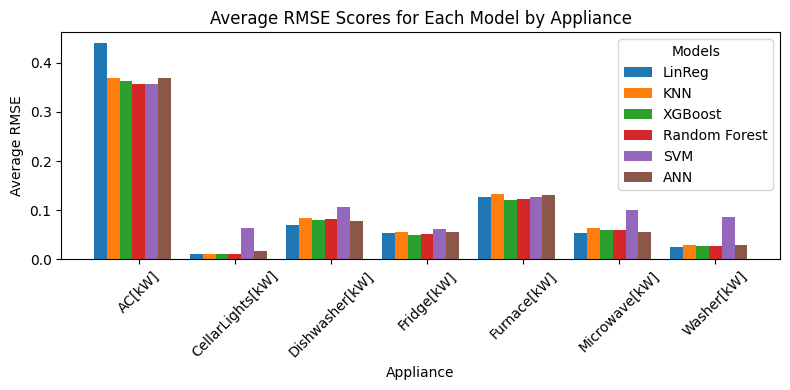

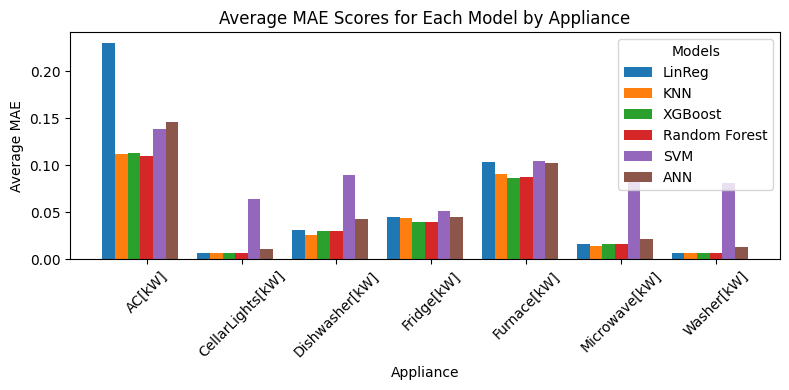

In [163]:
plot_rmse_scores(average_rmse, 'RMSE')
plot_rmse_scores(average_mae, 'MAE')

In [164]:
X_test, y_test = create_windowed_dataset(df_homeB_test, window_size)
xgboost_model = trained_models['XGBoost']
predictions = xgboost_model.predict(X_test)


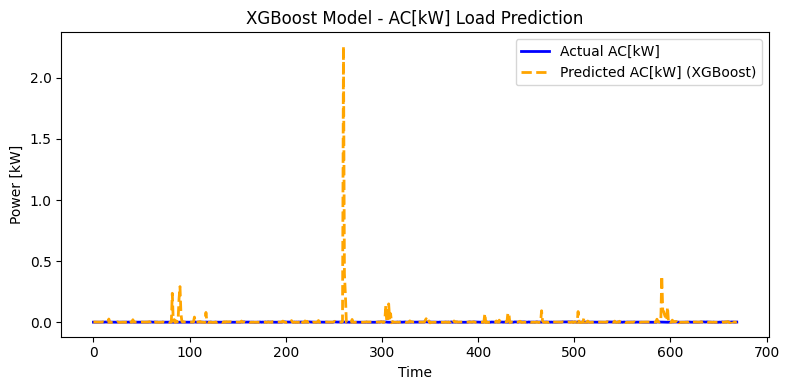

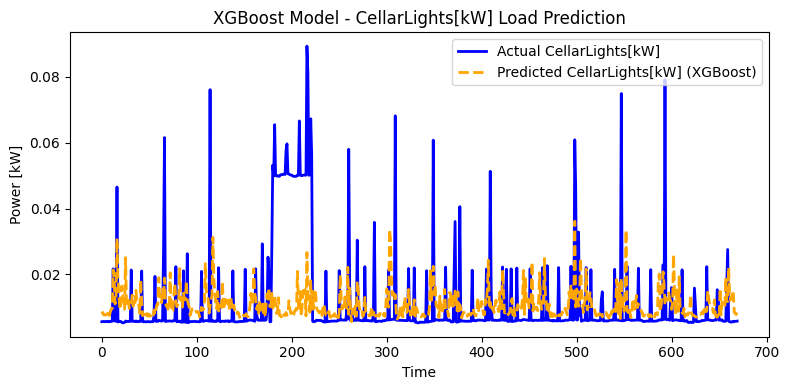

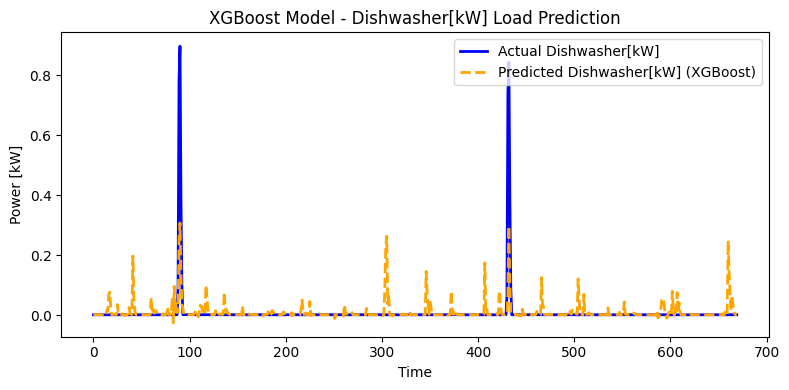

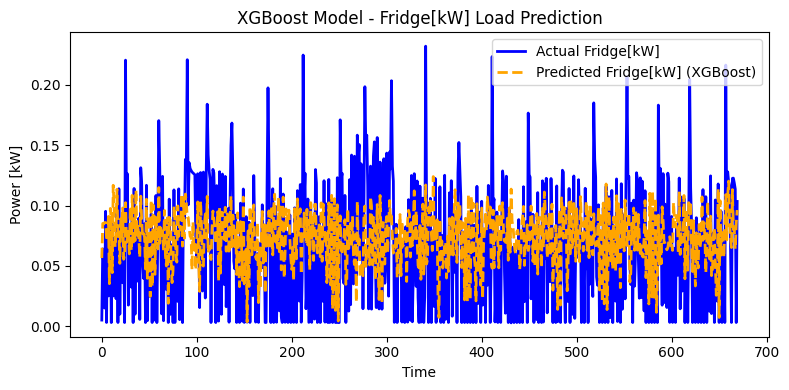

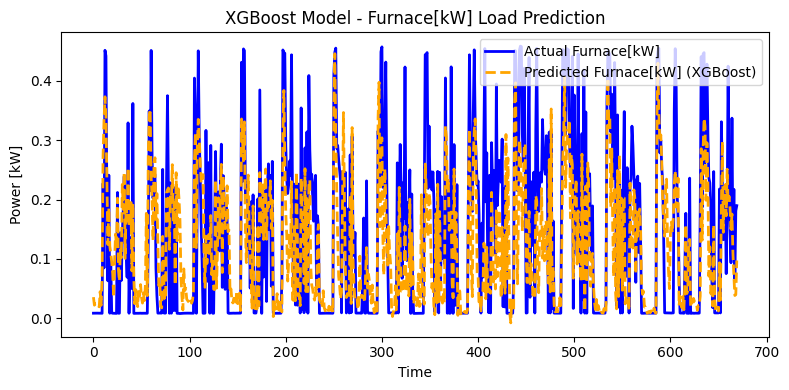

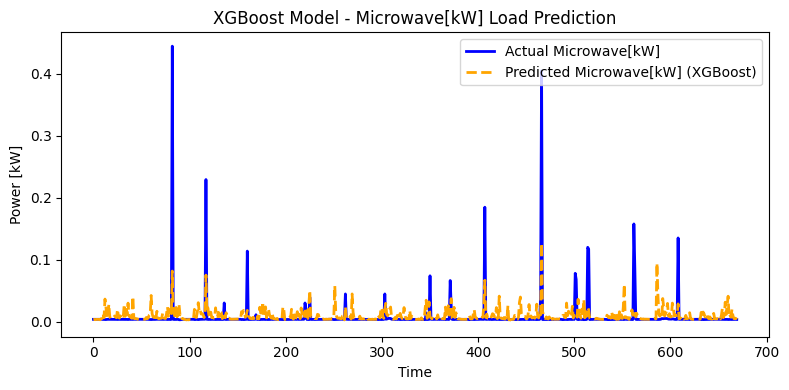

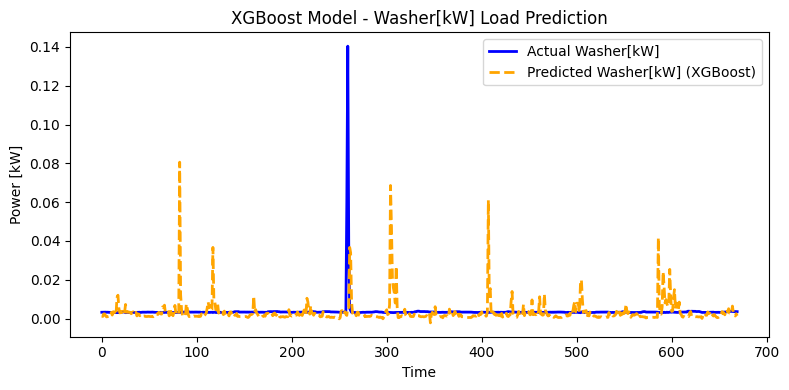

In [171]:
plot_predictions_vs_actuals(X_test, y_test, predictions, model_name='XGBoost')

In [169]:
mse_results = {}
mae_results = {}
for i, appliance in enumerate(y_test.keys()):
    # Compute MSE for each appliance
    mse = mean_squared_error(y_test[appliance], predictions[:, i], squared=False)
    mae = mean_absolute_error(y_test[appliance], predictions[:, i])
    mse_results[appliance] = mse
    mae_results[appliance] = mae
    #print(f"RMSE for {appliance}: {mse:.4f}")
    print(f"MAE for {appliance}: {mae:.4f}")
    print()

MAE for AC[kW]: 0.0100

MAE for CellarLights[kW]: 0.0082

MAE for Dishwasher[kW]: 0.0127

MAE for Fridge[kW]: 0.0374

MAE for Furnace[kW]: 0.0718

MAE for Microwave[kW]: 0.0082

MAE for Washer[kW]: 0.0030



In [168]:
average_mae['XGBoost']

{'AC[kW]': 0.1128059786695947,
 'CellarLights[kW]': 0.006744886043993173,
 'Dishwasher[kW]': 0.030108519047794692,
 'Fridge[kW]': 0.039772096547239524,
 'Furnace[kW]': 0.08697430642380581,
 'Microwave[kW]': 0.01626658222134924,
 'Washer[kW]': 0.006647963298440873}